In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from openTSNE import TSNE
from scipy.ndimage import convolve
from scipy.stats import gaussian_kde
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import plot_model, to_categorical

# **Analysis of Machine Learning Models and Statistical Methods on MNIST Data**

Author: Kyra Cho

**Outline of Contents:**
- The Tools and Libraries Utilized for Statistical Analysis, Visualization, and Machine Learning
- Introducing the MNIST Dataset
- Data visualization and exploratory data analysis:
    - The Histogram of Pixel Intensities
    - The t-Distributed Stochastic Neighbor Embedding (t-SNE)
    - The Distribution of Digits
    - The Average Digits Visualization
- The classification models:
    - The Random Forests model
    - The Multinomial Logistic Regression model
    - The Dense Neural Network model
    - The Convolutional Neural Network (CNN) model
    - The Simple Residual Neural Network (ResNet) model
    - Model Comparison
<br>
### **The Tools and Libraries Utilized for Statistical Analysis, Visualization, and Machine Learning**
- **Seaborn , Matplotlib:** The tool used for visualizing throughout this exercise is Seaborn. Seaborn relies on Matplotlib for the underlying plotting functionality, making Matplotlib a required dependency for Seaborn to work. Generally, it's an attractive visualization tool for statistical analysis. 

- **Tensorflow:** TensorFlow is an open-source machine learning framework developed by Google, designed for high-performance numerical computation and large-scale machine learning. Keras, which is integrated into TensorFlow, is a high-level neural networks API that allows for easy and fast prototyping, experimentation, and deployment of deep learning models. Together, they provide a great environment for developing, training, and deploying machine learning models.

- **Various statistical tools:**
    - Bar plot
    - Classification reports
    - Confusion matrices
    - Histogram
    - Machine learning algorithms
    - t-SNE plot

### **Introducing the MNIST Dataset**
The MNIST dataset, short for Modified National Institute of Standards and Technology dataset, is a large collection of handwritten digits. The dataset consists of 70,000 grayscale images, each of size 28x28 pixels, resulting in 784 features per image. There are 256 possible values per feature, each value corresponding to a color intensity. 0 is black, 255 is white, and values between represent varying shades of grey. The dataset is divided into a training set of 60,000 images and a test set of 10,000 images. Each image in the MNIST dataset represents a handwritten digit ranging from 0 to 9, labeled accordingly.


### **Histogram of Pixel Intensities**

The following histogram of pixel intensities shows the distribution of the grayscale values (ranging from 0 to 255) across all pixels in the dataset.

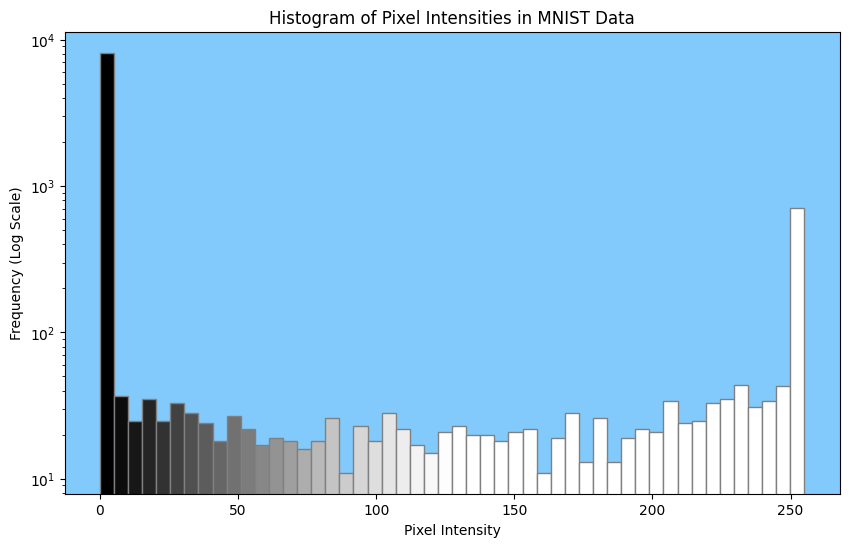

In [89]:
# Load data
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]

# Flatten the arrays
pixels = train_x.reshape(-1)

# Assuming 'pixels' is defined
sample_size = 10000
sampled_pixels = np.random.choice(pixels, size=sample_size, replace=False)

# Create a gradient color palette
cmap = plt.get_cmap("Greys_r")

# Plot the histogram using Seaborn
plt.figure(figsize=(10, 6))
hist_data = sns.histplot(sampled_pixels, bins=50, color='blue', alpha=0.75, edgecolor='grey')

# Normalize the bin centers for color mapping
bin_centers = 0.5 * (hist_data.patches[0].xy[0] + hist_data.patches[-1].xy[0])
normalized_bin_centers = np.array([patch.xy[0] for patch in hist_data.patches]) / bin_centers

# Set color of each patch based on normalized bin centers
for center, patch in zip(normalized_bin_centers, hist_data.patches):
    patch.set_facecolor(cmap(center))

# Set the background color to grey
plt.gca().set_facecolor('tan')
plt.gca().patch.set_facecolor('xkcd:sky')

# Set the y-axis to log scale
plt.yscale('log')
plt.title('Histogram of Pixel Intensities in MNIST Data')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency (Log Scale)')
plt.show()

***Figure 1: Histogram of pixel intensities in NMIST data.***

**Analysis of Figure 1:** The histogram indicates that the pixel values 0 and 255 are the most common. This is consistent with the fact that most of the MNIST images have a black or very dark background. Since the images are grayscale, the background pixels will have intensity values close to 0. This leads to a large number of pixels with very low intensity values. On ther other hand, the strokes that form the digits are white. Therefore, these pixels have intensity values close to 255. The over-representation of the darkest and lightest colors in MNIST data reflects the nature of the images: high contrast between the digit strokes and the background, which is beneficial for digit classification.

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**

Although each image in the MNIST dataset represents a single digit, each image has a high number of features per image $(28 \times 28 = 784)$. The t-distributed stochastic neighbor embedding (t-SNE) algorithm visualizes a sample from the MNIST dataset in a two dimensional plot. 

The algorithm converts high-dimensional Euclidean distances between data points into conditional probabilities representing similarities. The algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.

For two points $x_i$ and $x_j$, the similarity is modeled by a Gaussian distribution:
$$p_{j|i} = \frac{\exp\left(-\frac{\| x_i - x_j \|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\| x_i - x_k \|^2}{2\sigma_i^2}\right)}$$
and symmetrised as
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$
where $\sigma_i$ is the bandwidth of the Gaussian kernel for point $x_i$ and $N$ is the number of data points. In the low-dimensional space, t-SNE aims to maintain these similarities using a Student's t-distribution with one degree of freedom (which has heavier tails than a Gaussian). The similarity between two points $y_i$ and $y_j$ in the low-dimensional space is given by:
$$q_{ij} = \frac{\left(1 + \| y_i - y_j \|^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \| y_k - y_l \|^2\right)^{-1}}$$
The locations of the low-dimensional points $y_i$ are then found by minimizing the Kullback-Leibler divergence between the joint probabilities $p_{ij}$ and $q_{ij}$:
$$C = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.$$
This objective is minimized using gradient descent to reveal a meaningful 2D representation of the high-dimensional data.

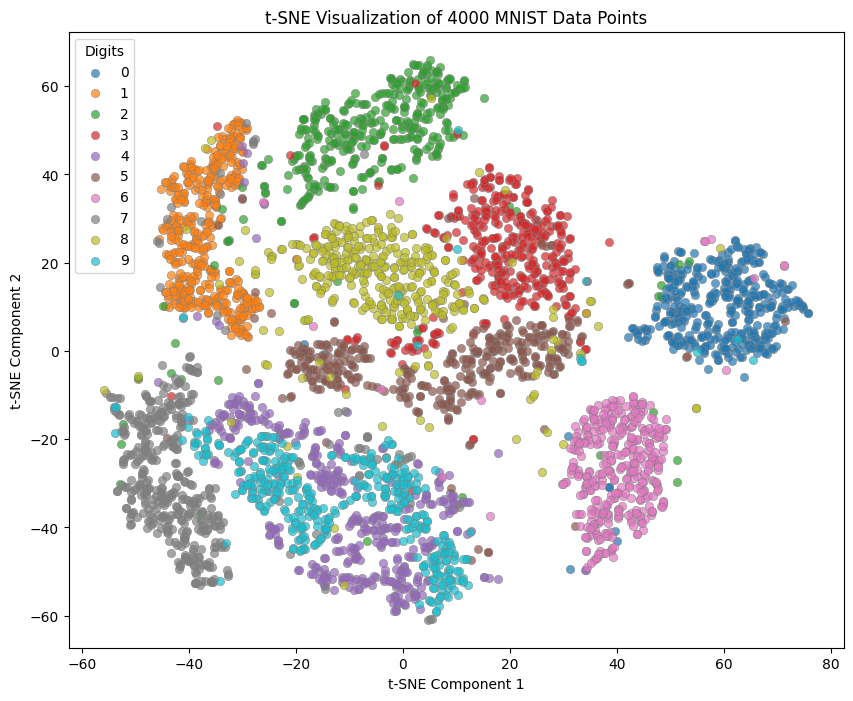

In [90]:
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]
    
# Flatten the images (from 28x28 to 784x1)
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

# Set the seed for reproducibility
np.random.seed(42)

# Sample 4000 data points randomly from MNIST
sample_size = 4000
indices = np.random.choice(train_x.shape[0], size=sample_size, replace=False)
X_sample = train_x[indices]
y_sample = train_y[indices]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)


plt.figure(figsize=(10, 8))

# Create a color palette
palette = sns.color_palette("tab10", 10)

# Plot each class with a different color
for i in range(10):
    sns.scatterplot(
        x=X_tsne[y_sample == i, 0], 
        y=X_tsne[y_sample == i, 1], 
        color=palette[i], 
        label=str(i), 
        alpha=0.7, 
        edgecolor='grey', 
        linewidth=0.5
    )
plt.title('t-SNE Visualization of {} MNIST Data Points'.format(sample_size))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title="Digits")
plt.show()

***Figure 2: t-SNE visualization of 4000 MNIST data points***

**Analysis of Figure 2:** In the t-SNE plot of 4000 MNIST data points, we see clusters of points that correspond to different digit classes (0-9). Each cluster represents a distinct digit, with points in the same cluster sharing similar characteristics. The t-SNE algorithm reduces the high-dimensional data to a two-dimensional space while preserving local structures, so points that are close in the high-dimensional space are also be close in the 2D plot. The plot has different colors for each digit, as indicated by the legend, making it easier to visually distinguish between the different clusters. There are some overlap or mixing between clusters, particularly for digits that are visually similar, such as '4' and '9', as well as '3', '5', and '8'. But overall, the t-SNE plot reveals clear groupings corresponding to the individual digits. For a data set with $n$ elements, t-SNE runs in $O(n^2)$ time and requires $O(n^2)$ space.

### **Distribution of Digits**

The distribution of digits bar graph provides a quick visual summary of the dataset and identifies any class imbalance by showing the frequency of each digit class.

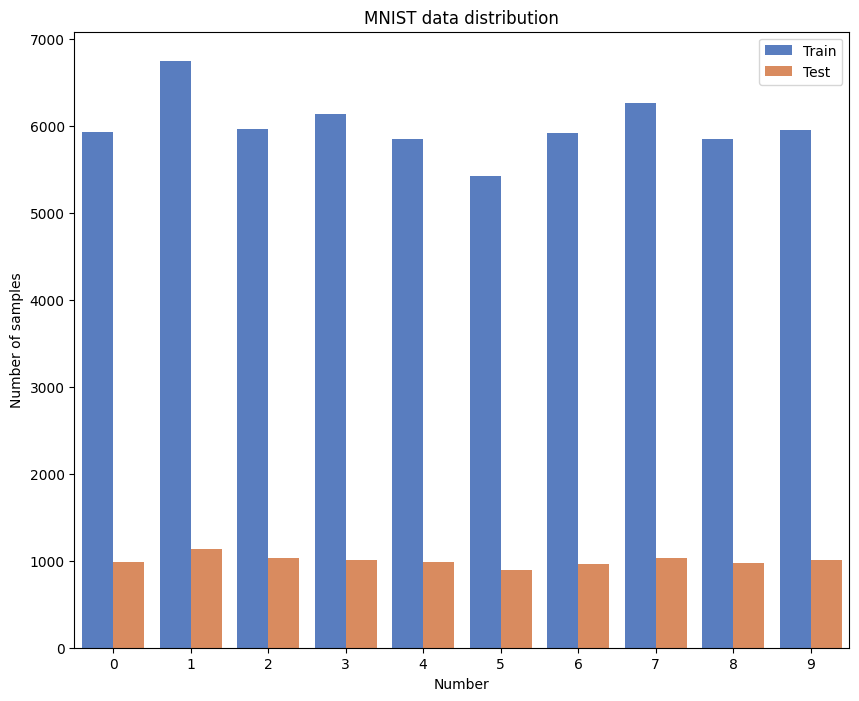

In [91]:
# Count number of samples for each class and plotting them
(_, train_count) = np.unique(train_y, return_counts=True)
(_, test_count) = np.unique(test_y, return_counts=True)

plt.figure(figsize=(10, 8))
plt.title('MNIST data distribution')
plt.xticks(range(10), labels=range(10))
plt.xlabel('Number')
plt.ylabel('Number of samples')

# Create a DataFrame for Seaborn
data = {'Number': np.tile(range(10), 2),
        'Count': np.concatenate([train_count, test_count]),
        'Dataset': ['Train'] * 10 + ['Test'] * 10}

# Plot with Seaborn
sns.barplot(x='Number', y='Count', hue='Dataset', data=data, palette='muted')
plt.legend()
plt.savefig('DataDistribution.png')
plt.show()

***Figure 3: MNIST data distribution***

**Analysis of Figure 3:** The bar plot visualizes the distribution of each digit in the training set. Ideally, the heights of the bars should be similar, indicating a balanced dataset. The plot shows differences in the counts of digits in the training set, indicating class imbalance. A balanced dataset is crucial for training machine learning models to ensure that the model does not become biased towards more frequently occurring classes. However, MNIST has a high level of redundancy, and its data are rich in features, making class imbalance a minor concern.

## **Average Digits**

The average digits analysis of the MNIST classes involves computing the average pixel values for each digit class (0 through 9) to generate a composite image representing the "average" appearance of each digit.

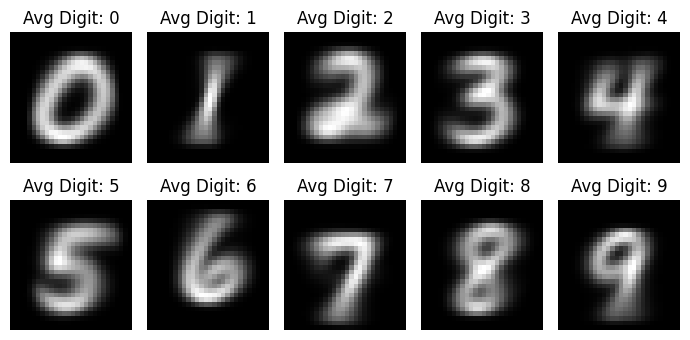

In [5]:
# Create a figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(7, 3.5))

# Loop over each digit from 0 to 9
for i in range(10):
    # Determine the current subplot based on the digit
    ax = axes[i // 5, i % 5]
    
    # Calculate the average image for the current digit
    avg_image = train_x[train_y == i].mean(axis=0).reshape(28, 28)
    
    # Plot the average image using a heatmap
    sns.heatmap(avg_image, cmap='gray', ax=ax, cbar=False)
    
    # Set the title of the subplot to indicate the digit
    ax.set_title(f'Avg Digit: {i}')
    
    # Turn off the axis labels
    ax.axis('off')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

***Figure 4: Average digits***

**Analysis of Figure 4:** This visualization provides the averages of the images, so distinctive features that are common across many instances of a digit can be highlighted, while noise and individual variations are smoothed out. This can be useful for identifying the most salient features of each digit. It is also useful for assessing the quality and consistency of the dataset. Significant deviations in the average image might indicate issues with data labeling or preprocessing. The white areas are crucial for classification and grey areas pose learning challenges.

In [92]:
# Define the function to plot the training history using Seaborn
def plot_history(history, filename, model_name, epochs):
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
    fig, ax1 = plt.subplots(figsize=(10, 7))
    
    plt.title(f'{model_name} model learning curve - Max accuracy on test is {max(history.history["val_accuracy"]):.4f}')
    
    ax1.set_xlabel('Epochs')
    ax1.set_xticks(range(epochs))
    ax1.set_ylabel('Loss')
    
    sns.lineplot(x=range(epochs), y=history.history['loss'], ax=ax1, color='r', label='Train Loss')
    sns.lineplot(x=range(epochs), y=history.history['val_loss'], ax=ax1, color='orange', label='Test Loss')
    ax1.axvline(best_epoch, color='m', lw=2, alpha=0.5, label='Best epoch')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    
    sns.lineplot(x=range(epochs), y=history.history['accuracy'], ax=ax2, color='g', label='Train Accuracy')
    sns.lineplot(x=range(epochs), y=history.history['val_accuracy'], ax=ax2, color='b', label='Test Accuracy')
    ax2.legend(loc='upper right')
    
    plt.savefig(filename)
    plt.show()

# Define the function to plot the first 25 samples with labels using Seaborn
def plot_first25labels(test_x, test_y, test_y_hat):
    # Plotting the first 25 samples with labels
    plt.figure(figsize=(7, 7))
    plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual label -> Estimated label')
    
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
        sns.heatmap(test_x[i, :, :], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Define the function to plot mislabeled samples using Seaborn
def plot_mislabeled(test_x, test_y, test_y_hat):
    # Plotting the first 25 mislabeled samples
    rows = np.where(test_y_hat != test_y)[0]
    if len(rows) < 25:
        raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))
    
    plt.figure(figsize=(7, 7))
    plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual label -> Estimated label')
    
    for i in range(25):
        index = rows[i]
        plt.subplot(5, 5, i + 1)
        plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
        sns.heatmap(test_x[index, :, :], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Define the function to plot the confusion matrix using Seaborn
def plot_confusion(test_y, test_y_hat, model_name):
    cm = confusion_matrix(test_y, test_y_hat, normalize='true')
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='viridis', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix of {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## **The Random Forests Model**
<img src="mnist_classification_pics/1.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 500px;"> 

Random Forests is an ensemble learning algorithm for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. The training algorithm for random forests applies the general technique of bootstrap aggregating.

**Bootstrap Aggregating:** Given a standard training set $D$, of size $n$, bootstrap aggregating generates $m$ new training sets $D_i$, each of size $n^*$, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations are expected to be repeated in each $D_i$. If $n^*=n$, then for large $n$ the set $D_i$ $\frac{(1 - 1)}{e} \approx 63.2\%$ of the unique examples of $D$, the rest being duplicates. This kind of sample is known as a bootstrap sample. Sampling with replacement ensures each bootstrap is independent from its peers, as it does not depend on previous chosen samples when sampling. 

Then, $m$ models are fitted using the above $m$ bootstrap samples. After training, predictions for unseen samples $x$ can be made by taking the plurality vote on individual classification trees on $x$.

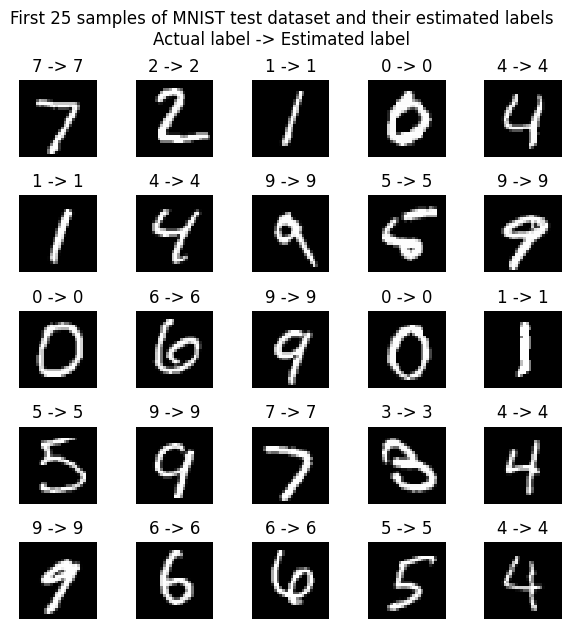

In [93]:
# Load data
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]
    
# Reshape train_x and test_x to (num_samples, 784)
train_x_flattened = train_x.reshape(train_x.shape[0], -1)
test_x_flattened = test_x.reshape(test_x.shape[0], -1)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(train_x_flattened, train_y)

# Predict on the test set
test_predictions = rf_classifier.predict(test_x_flattened)

# Calculate accuracy
random_forests_accuracy = accuracy_score(test_y, test_predictions)

# Plot correctly labeled images
plot_first25labels(test_x, test_y, test_predictions)


***Figure 5: The first 25 images labeled by the Random Forest model***

**Analysis of Figure 5:** Visualization of 25 labeled MNIST images classified using the Random Forest model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

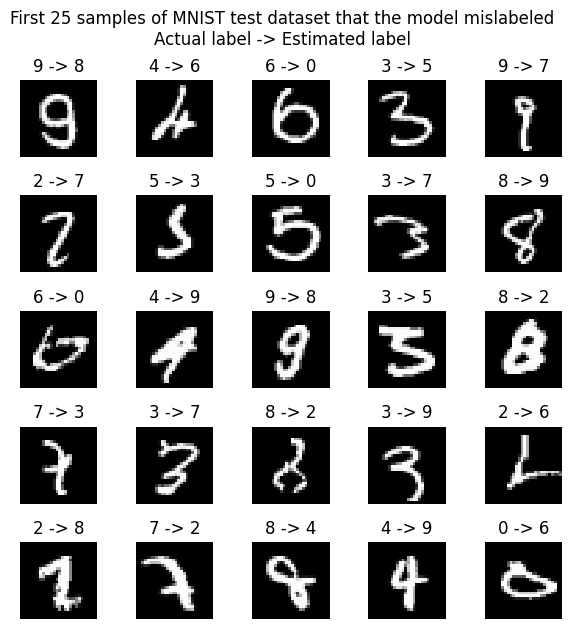

In [94]:
# Plot mislabeled images
plot_mislabeled(test_x, test_y, test_predictions)

***Figure 6: The first 25 images mislabeled by the Random Forest model***

**Analysis of Figure 6:** Visualization of 25 incorrectly labeled MNIST images classified using the Random Forest model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits.

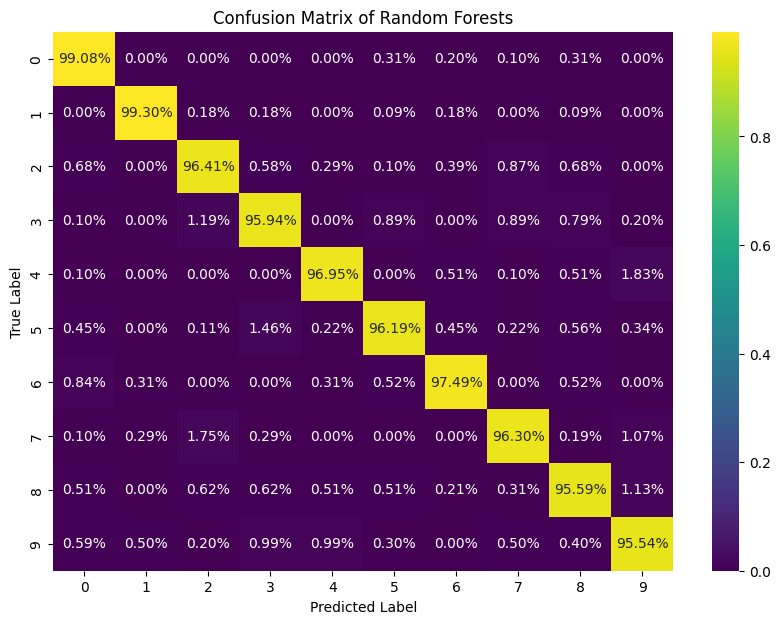

In [95]:
# Plot the confusion matrix
model_name = 'Random Forests'
plot_confusion(test_y, test_predictions, model_name)

***Figure 7: The confusion matrix of the Random Forest model***

**Analysis of Figure 7:**  Confusion matrix for the Random Forest model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that some digits were more accurately labeled than others. The digits '0' and '1' were the most accurately labeled, while the digits '3', '8', and '9' were the least accurately labeled. 

In [96]:
# Print classification report
print('The Random Forest Model Classification Report:')
print(classification_report(test_y, test_predictions, labels=[str(i) for i in range(10)]))

The Random Forest Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



The Random Forest model'sclassification report for the MNIST dataset demonstrates strong performance across all digit classes. The overall precision, recall, and F1-score are consistently high, with an average value of 0.97. The model performs exceptionally well on digits '0', '1', and '6', achieving an F1-score of 0.98, 0.99, and 0.98, respectively. While digits '2', '3', '8', and '9' show slightly lower performance with F1-scores, they still indicate robust classification. The micro, macro, and weighted averages all confirm the model's reliability, with an accuracy of 0.97 across the entire test set of 10,000 samples.

In [97]:
# Load data for the neural networks
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]

# Normalize input
train_x = train_x.astype('float') / 255.0
test_x = test_x.astype('float') / 255.0

# Preprocess input
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

# Hyperparameters
Epochs = 10 
BatchSize = 32 

Shape of train_x is : (60000, 28, 28, 1) (min= 0.00, max= 1.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


In [98]:
# One-hot encoding is necessary to match the expected input format of the categorical cross-entropy loss function.
one_hot_train_y = to_categorical(train_y, num_classes=10)
one_hot_test_y = to_categorical(test_y, num_classes=10)
print('Shape of one_hot_train_y is : ' + str(one_hot_train_y.shape))
print('Shape of one_hot_test_y is : ' + str(one_hot_test_y.shape))

Shape of one_hot_train_y is : (60000, 10)
Shape of one_hot_test_y is : (10000, 10)


## **Multinomial Logistic Regression**
<img src="mnist_classification_pics/2.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 500px;"> 

Multinomial logistic regression is a classification method that generalizes logistic regression to multiclass problems. It is a model that is used to predict the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables.

In the training set $\{x^{(1)},\hat{y}^{(1)},...,x^{(60,000)},\hat{y}^{(60,000)}\}$, we have $\hat{y}^{(i)}\in\{1,...,10\}$. We want to estimate the probability of the class label taking on each of the $10$ different possible values. Our model outputs the maximum of a $10$-dimensional vector representing $10$ estimated probabilities. 

**Linear predictor:** 
$$z_{j}^{(i)} = b_{j}^{(i)} + w_{j1}^{(i)}x_1^{(i)}+ w_{j2}^{(i)}x_2^{(i)} + \cdots + w_{jp}^{(i)}x_{p}^{(i)}$$
The linear predictor is output by the inear combination of the input features and the model parameters, which are initially randomly distributed. The linear preditor for the $i$-th image and the $j$-th class is given by the above equation, where $b_{j}^{(i)}$ is the bias term (which is initially randomly chosen, then optimized to minimize the loss model), $w_{jk}^{(i)}$ are the parameters (also randomly chosen, then optimized) for the input features, and $x_{k}^{(i)}$ are the input features for the $i$-th image. There are $10+ 784 * 10 $ parameters that are updated during each backward pass. 

**Softmax:** 
$$a_{j}^{(i)}= \frac{e^{z_{j}^{(i)}}}{\sum_{k=1}^{10} e^{z_{k}^{(i)}}}$$

The softmax function converts the raw output scores from the linear predictors into probabilities that sum to one (i.e., normalized). The probabilities are used in the cost function., typically the cross-entropy loss. $a_{j}^{(i)}$ is the predicted probability that the $i$-th image belogs to the $j$-th class, i.e., the linear predictor for the $i$-th image and the $j$-th class. 


**Categorical Cross-Entropy:** 
$$\mathcal{L} = -\sum_{i=1}^m\sum_{j=1}^{10} \hat{a}_j^{(i)} \log a_{j}^{(i)}$$
The categorical cross-entropy is loss a function, $\mathcal{L}$, that measures the difference between the predicted probabilities and the actual class labels, guiding the optimization process to adjust the model parameters to minimize this difference. $\hat{a}_j^{(i)} $ is a binary indicator (0 or 1) that is 1 if the actual class of example $i$ is $j$, and 0 otherwise. $a_{j}^{(i)}$ is the predicted probability that example $i$ belogs to class $j$, obtained from the softmax function. The loss function is computed once for every batch of size $m$. In the current model, the batch size is $32$. 

**Stochastic Gradient Descent (SGD):** An optimization algorithm to find the parameter values that minimize the loss function. The process involves calculating the gradient of the loss function with respect to the parameters and iteratively updating the parameters in the direction that reduces the cost. The SGD introduces randomness into the gradient descent process by updating model parameters after computing the loss function for each batch. This randomness leads to fluctuations in the parameter values. 

**The Model:**
This instance of the model is built using the Keras API. It has an input layer, a flattening layer, and an outer layer with softmax activation. It models the probability of each class as a linear combination of input features, translated by the bias, followed by the softmax function, which converts these linear scores into probabilities that sum to one. During each backward pass, SGD is used to update the model parameters to minimize the loss function. In this model, there are 60,000 backward passes. 

In [99]:
# Define the input layer with the shape of the MNIST images (28x28 pixels, 1 channel)
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# Flatten the input image to a 1D vector (28x28=784 elements)
x = layers.Flatten(name='FlattenLayer')(inp)

# Define the output layer with 10 units (one for each digit) and a softmax activation function
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)

# Create the model by specifying the input and output layers
model = Model(inp, outp, name='DenseModel')
model.summary()

# Compile the model with categorical cross-entropy loss, stochastic gradient descent optimizer, and accuracy as a metric
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

Model: "DenseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='LinearModelCheckPoints/best_mle_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='LinearModelCheckPoints/mle_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6994 - loss: 1.1715 - val_accuracy: 0.8819 - val_loss: 0.4796
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.8775 - loss: 0.4788 - val_accuracy: 0.8948 - val_loss: 0.3996
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.8891 - loss: 0.4144 - val_accuracy: 0.9023 - val_loss: 0.3655
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.8962 - loss: 0.3842 - val_accuracy: 0.9065 - val_loss: 0.3472
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.9018 - loss: 0.3606 - val_accuracy: 0.9082 - val_loss: 0.3353
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.9026 - loss: 0.3543 - val_accuracy: 0.9105 - val_loss: 0.3259
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.9059 - loss: 0.3396 - val_accuracy: 0.9120 - val_loss: 0.3194
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.9078 -

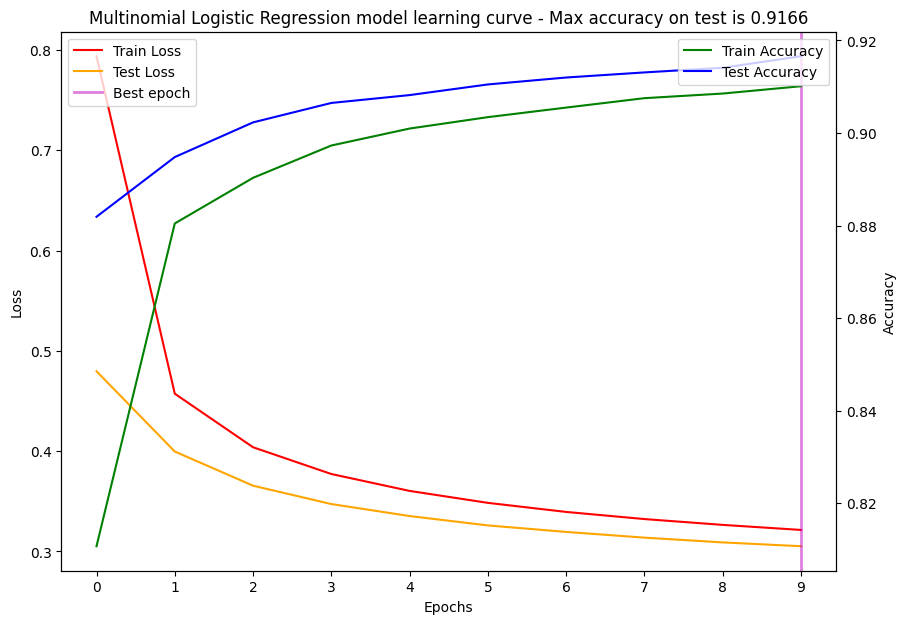

In [101]:
filename = 'LinearModelLearningCurve.png'
model_name = 'Multinomial Logistic Regression'
plot_history(history, filename, model_name, Epochs)

***Figure 8: Multinomial Logistic Regression model learning curve.***

**Analysis of Figure 8:** The learning curve of the Multinomial Logistic Regression model indicates a strong learning performance, with the maximum accuracy of $0.9166$. The minimum test loss was achieved at the 9th epoch, which signifies the point at which the model performed best on the validation set. The learning curve demonstrates steady improvement in accuracy over the epochs, highlighting the model's capacity to learn and generalize from the training data effectively up to this optimal point.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


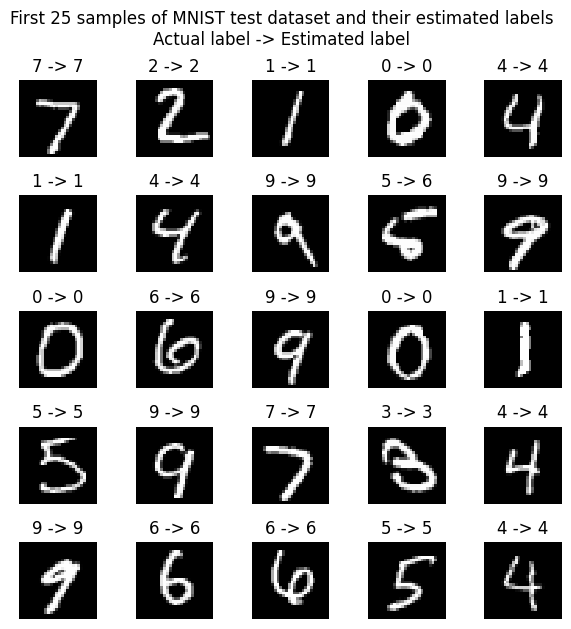

In [102]:
# Load best model (least validation loss)
model = load_model('LinearModelCheckPoints/best_mle_model.keras')
# Evaluate model on test set
test_y_hat = model.predict(test_x)
# Find max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)
MLR_accuracy = accuracy_score(test_y, test_y_hat)

***Figure 9: The first 25 images labeled by the Multinomial Logistic Regression model***

**Analysis of Figure 9:** Visualization of 25 labeled MNIST images classified using the Multinomial Logistic Regression model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

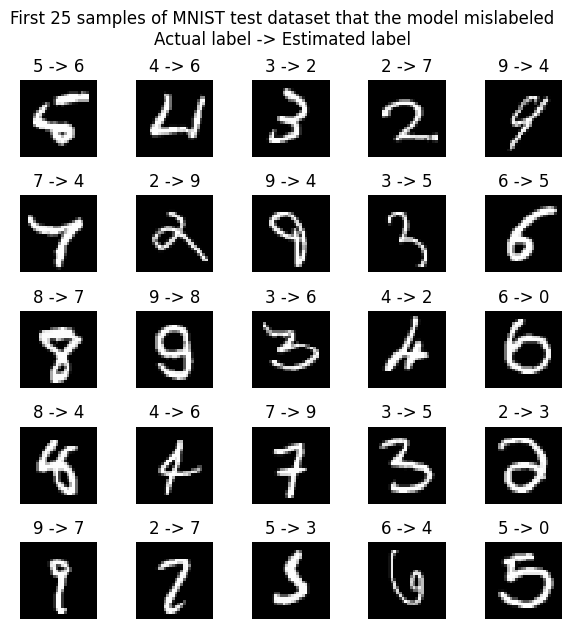

In [103]:
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 10: The first 25 images mislabeled by the Multinomial Logistic Regression model***

**Analysis of Figure 10:** Visualization of 25 incorrectly labeled MNIST images classified using the Multinomial Logistic Regression model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

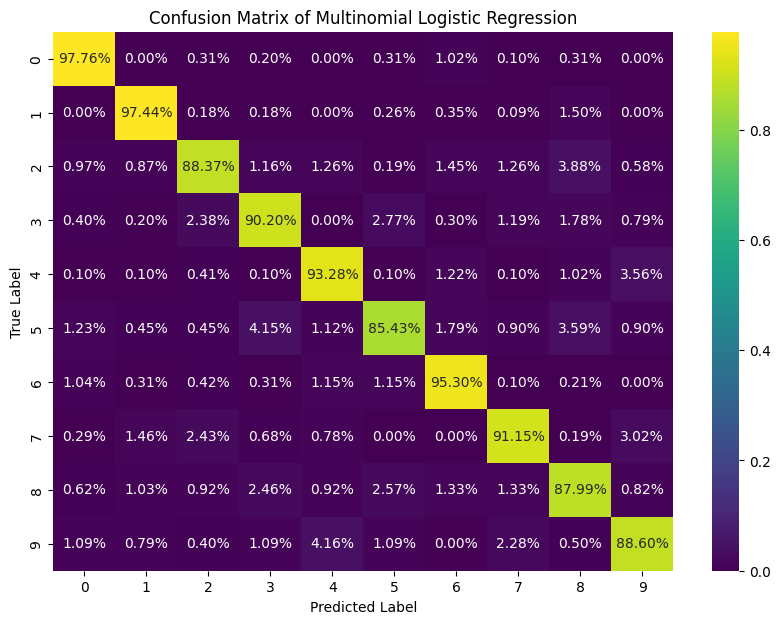

In [104]:
plot_confusion(test_y, test_y_hat, model_name)

***Figure 11: The confusion matrix of the Multinomial Logistic Regression model***

**Analysis of Figure 11:** Confusion matrix for the Multinomial Logistic Regression model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that some digits were more accurately labeled than others. The digits '0' and '1' were the most accurately labeled, while the digits '2', '5', '8', and '9' were the least accurately labeled.

In [105]:
# Print classification report
print('Multinomial Logistic Regression Classification report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

Multinomial Logistic Regression Classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.97      0.96      1135
           2       0.92      0.88      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.90      0.85      0.88       892
           6       0.93      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.87      0.88      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



The classification report for the Multinomial Logistic Regression model on the MNIST dataset shows decent performance with an accuracy of 0.92. The model excells in recognizing digits '0' and '1', with F1-scores of 0.96 and 0.97. Digits '5', '8', and '9' have slightly lower F1-scores around 0.87 to 0.89. Digits '3', '4', '6', and '7' perform solidly, with F1-scores between 0.90 and 0.94. Macro and weighted averages for precision, recall, and F1-score are consistently around 0.92, indicating reliable classification across all classes.

## **Simple Neural Network**

<img src="mnist_classification_pics/3.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 500px;"> 

Simple neural networks differ from MLR by having additional layers of neurons called hidden layers. Hidden layers are basicically interconnected nodes, where each connection has an associated weight and each node has a bias and an activation function. Input data is processed through these layers using activation functions such as the rectified linear unit (relu) or softmax. The network learns by adjusting weights and biases during training to minimize the loss function during each backward pass. 

**The Rectified Linear Unit (relu) Function:**
$$\text{relu}(x)=\text{max}(0,x)$$
In hidden layers, relu activation is used over sigmoid activation because relu mitigates the vanishing gradient problem. 

**The Sigmoid Function:**

$$\begin{align*}S(x)=&\frac{1}{1+e^{-x}}\\
\frac{d}{dx}S(x)=&S(x)-S^2(x)\end{align*}$$

**The Vanishing Gradient Problem:** The derivative of relu is $1$ if $x>0$ and $0$ otherwise. The gradient doesn't diminish as it propagates through layers, meaning that updates to the parameters don't dimish. On the other hand, the sigmoid function can have gradients that approach $0$ (when the input is very large or very small), which means during backpropagation gradients can become very small, leading to too-small adjustments of the model parameters. 


**Backpropagation:** Backpropagation, short for backward propagation of errors, is an algorithm for supervised learning of artificial neural networks using gradient descent. The method calculates the gradient of the loss function with respect to the neural network's weights. 


This simple neural network has an input layer, a flatten layer, two dense layers, and an output layer. The first dense layer comprises 128 neurons, utilizing the ReLU activation function and the he_uniform kernel initializer (it means the initial weights are chosen randomly). The second dense layer, similar in configuration, contains 64 neurons. The final output layer consists of 10 neurons, each representing a class from 0 to 9, with the softmax activation function to output probability distributions over these classes. The model is compiled with categorical cross-entropy loss, the Stochastic Gradient Descent optimizer, and accuracy as the performance metric. The loss function is used to adjust the parameters, and accuracy is used to evaluate the model. 

**Example calculations for the parameters:**

There are $784*128+128=100480$ parameters in the first hidden layer. 

There are $128*64+64=8256$ parameters in the second hidden layer. 

There are $64*10+10=650$ parameters in the output layer. 

In [106]:
# Define model using the functional API

# Input layer: Accepts 28x28 grayscale images (1 channel)
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# Flatten layer: Converts 2D input image to a 1D array
x = layers.Flatten(name='FlattenLayer')(inp)

# First dense layer: 128 neurons, ReLU activation, He uniform initializer
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='DenseLayer1')(x)

# Second dense layer: 64 neurons, ReLU activation, He uniform initializer
x = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='DenseLayer2')(x)

# Output layer: 10 neurons (one for each class), softmax activation for classification
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)

# Create the model, linking the input and output
model = Model(inp, outp, name='DenseModel')

# Compile the model: Categorical cross-entropy loss, SGD optimizer, accuracy metric
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "DenseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer1 (Dense)             │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer2 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Train the model 
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='DenseModelCheckPoints/best_dense_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='DenseModelCheckPoints/dense_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.7085 - loss: 1.0629 - val_accuracy: 0.9123 - val_loss: 0.3040
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.9146 - loss: 0.2950 - val_accuracy: 0.9302 - val_loss: 0.2388
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.9304 - loss: 0.2387 - val_accuracy: 0.9395 - val_loss: 0.2056
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.9407 - loss: 0.2024 - val_accuracy: 0.9477 - val_loss: 0.1777
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - accuracy: 0.9501 - loss: 0.1746 - val_accuracy: 0.9523 - val_loss: 0.1615
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.9553 - loss: 0.1533 - val_accuracy: 0.9566 - val_loss: 0.1466
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - accuracy: 0.9608 - loss: 0.1388 - val_accuracy: 0.9594 - val_loss: 0.1350
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.9634 -

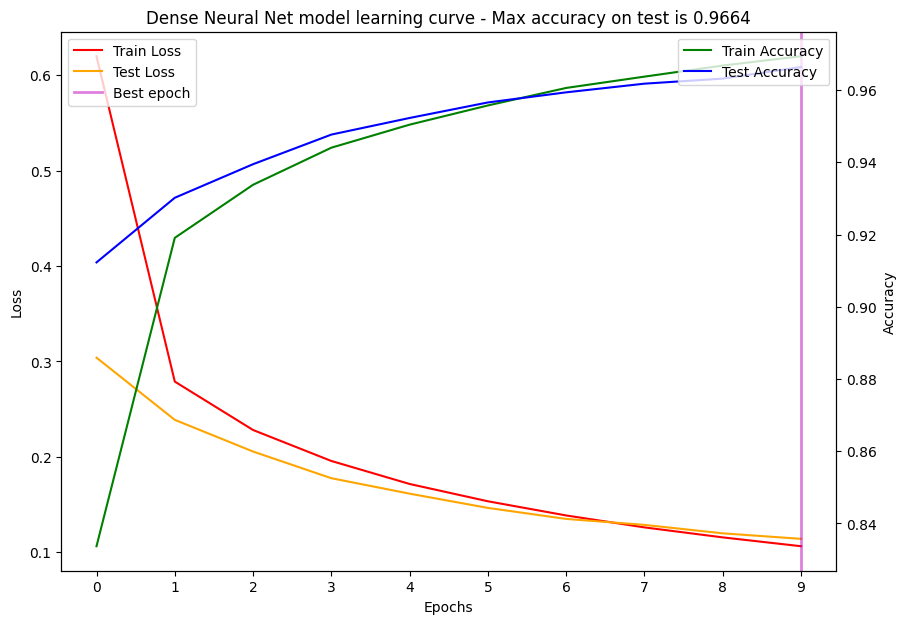

In [108]:
# Plot learning curves and labelling them
filename='DenseModelLearningCurve.png'
model_name = 'Dense Neural Net' 
plot_history(history, filename, model_name, Epochs)

***Figure 12: Dense Neural Network model learning curve.***

**Analysis of Figure 12:** The learning curve of the Dense Neural Network model indicates a strong learning performance, with the maximum accuracy reaching $0.9664$. The lowest test loss was achieved on the 9th epoch. The learning curve demonstrates steady improvement in accuracy over the epochs, highlighting the model's capacity to learn and generalize from the training data effectively up to this optimal point.

In [109]:
# Load best model (least validation loss)
model = load_model('DenseModelCheckPoints/best_dense_model.keras')

In [110]:
# Evaluate model on test set
test_y_hat = model.predict(test_x)
#print('test_y_hat shape is : ' + str(test_y_hat.shape))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


In [111]:
#finding max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
#print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
NN_accuracy = accuracy_score(test_y, test_y_hat)

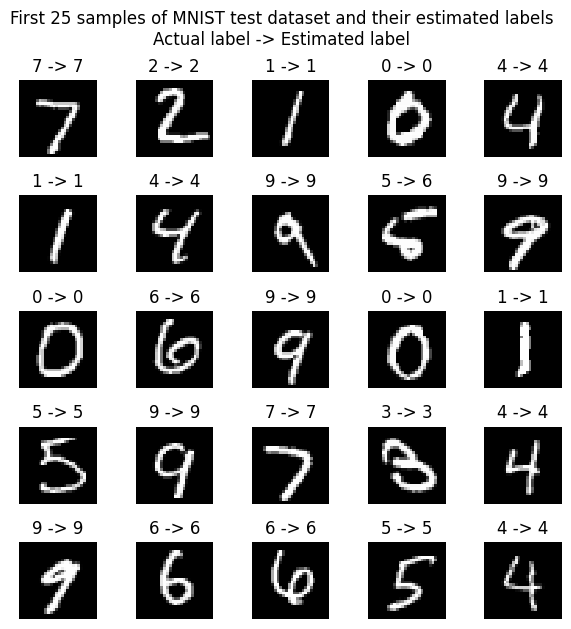

In [112]:
#plotting first 25 samples with labels
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 13: The first 25 images labeled by the Dense Neural Network model***

**Analysis of Figure 13:** Visualization of 25 labeled MNIST images classified using the Dense Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

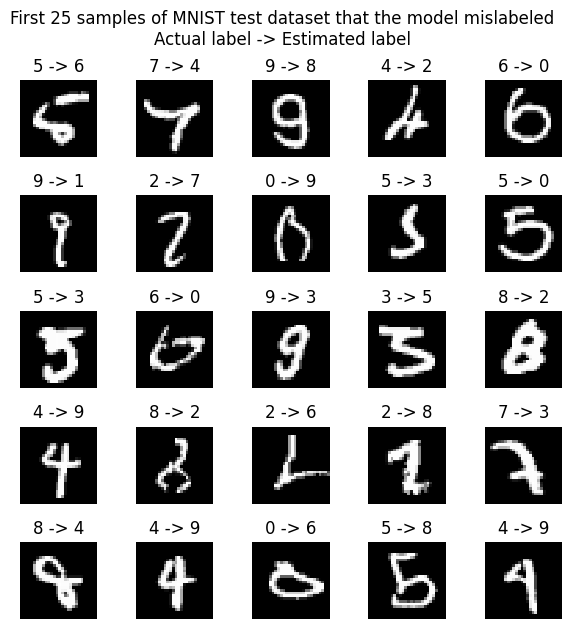

In [113]:
# Plot first 25 mislabled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 14: The first 25 images mislabeled by the Dense Neural Network model***

**Analysis of Figure 14:** Visualization of 25 incorrectly labeled MNIST images classified using the Dense Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

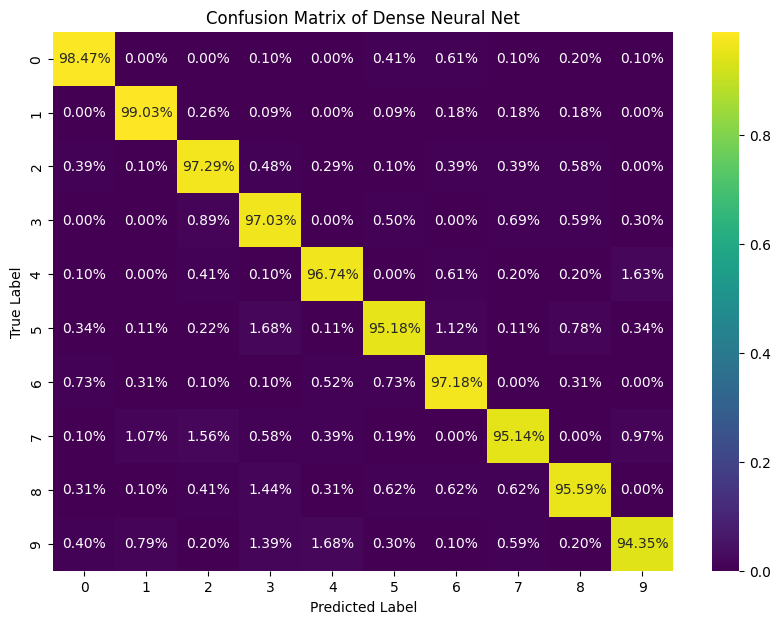

In [114]:
# Show the confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

***Figure 15: The confusion matrix of the Dense Neural Network model***

**Analysis of Figure 15:** Confusion matrix for the Dense Neural Network model classifying MNIST images. The digits '0' and '1' were the most accurately labeled, while the digits '5', '7', and '9' were the least accurately labeled.

In [115]:
# Print classification report
print('Dense Neural Network Classification Report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=3))

Dense Neural Network Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.985     0.981       980
           1      0.978     0.990     0.984      1135
           2      0.961     0.973     0.967      1032
           3      0.944     0.970     0.957      1010
           4      0.966     0.967     0.967       982
           5      0.967     0.952     0.959       892
           6      0.964     0.972     0.968       958
           7      0.971     0.951     0.961      1028
           8      0.969     0.956     0.962       974
           9      0.966     0.944     0.955      1009

    accuracy                          0.966     10000
   macro avg      0.966     0.966     0.966     10000
weighted avg      0.966     0.966     0.966     10000



The classification report for the Dense Neural Network model on the MNIST dataset shows an impressive overall accuracy of 0.966. Each digit class has high precision, recall, and F1-scores, with values above 0.95, indicating strong performance across all digits. The model performs exceptionally well on digits '0' and '1', with F1-scores of 0.981 and 0.984, respectively. Even the lowest performing digit, '9', maintains a solid F1-score of 0.955. The macro and weighted averages for all metrics are 0.966, reflecting the model's consistency and reliability.
<br><br>

## **Convolutional Neural Network**

<img src="mnist_classification_pics/4.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 800px;"> 

A Convolutional Neural Network (CNN) is a specialized type of neural network designed for processing structured grid data like the MNIST images. The key feature of CNNs is the convolutional layers, which apply convolutional filters to input data. Convolutional layers identify patterns such as edges, textures, and shapes, making CNNs more effective compared to simple neural networks for image recognition and classification tasks.

**Convolutional layers:** This particular CNN architecture includes three convolutional layers with relu activation and he_uniform initialization. The first convolutional layer applies 32 different $(3\times 3)$ filters (each of them randomly initialized as per the he_uniform kernel initializer) to the input data. 

For example, in the first convolutional layer, each filter generates a corresponding $(26\times 26)$ feature map. Each filter is associated with $3\times 3 = 9$ weights and $1$ bias parameter for a total of $10 * 32 = 320$ parameters. The relu activation is applied $26\times 26$ times for each feature map produced by each filter. The output of this layer $26 * 26 * 32 = 21632$ numbers. 

**Channels:** Each channel in a convolutional layer captures different aspects or representations of the input data. The number of channels after a convolutional layer corresponds to the number of filters, which is $32$ for the first convolutional layer.  

**MaxPooling layers:** MaxPooling reduces the spatial dimensions of the input feature map while maintaining the essential features necessary for accurate image recognition. It takes the maximum value from each non-overlapping $(2\times 2)$ blocks of the input. 

For the first MaxPooling layer, the output has $21632/4=5408$ numbers.

**Valid Padding:** Also called "no padding", valid padding means that no pixels were added to the border of the input images for the filters. This means the output feature map is smaller than the input data. 

In [116]:
# Define the input layer
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# First convolutional layer
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', name='Conv1')(inp)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling1')(x)

# Second convolutional layer
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', name='Conv2')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling2')(x)

# Flatten the output and feed it into a fully connected layer
x = layers.Flatten(name='FlattenLayer')(x)
x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform',name='DenseLayer1')(x)

# Output layer with 10 neurons (one for each class) and softmax activation
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)


model = Model(inp, outp, name='DenseModel')
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

model.summary()

Model: "DenseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1 (MaxPooling2D)      │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2 (MaxPooling2D)      │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer1 (Dense)             │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,926 (702.84 KB)

 Trainable params: 179,926 (702.84 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='ConvModelCheckPoints/best_conv_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='ConvModelCheckPoints/conv_model_{epoch:02d}.keras', save_best_only=False)])


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8545 - loss: 0.4853 - val_accuracy: 0.9717 - val_loss: 0.0976
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9688 - loss: 0.1051 - val_accuracy: 0.9805 - val_loss: 0.0641
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9782 - loss: 0.0750 - val_accuracy: 0.9830 - val_loss: 0.0540
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9828 - loss: 0.0574 - val_accuracy: 0.9852 - val_loss: 0.0462
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9847 - loss: 0.0497 - val_accuracy: 0.9859 - val_loss: 0.0426
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9878 - loss: 0.0412 - val_accuracy: 0.9846 - val_loss: 0.0469
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9888 - loss: 0.0374 - val_accuracy: 0.9882 - val_loss: 0.0382
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9893 - loss: 0.0350 -

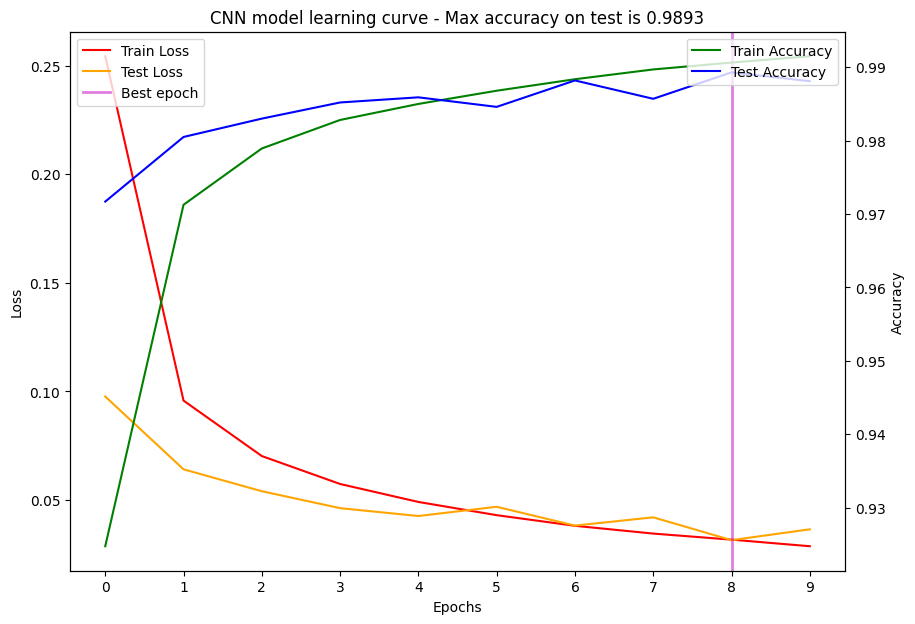

In [118]:
# Plot learning curves and labelling them
filename='ConvModelLearningCurve.png'
model_name = 'CNN' 
plot_history(history, filename, model_name, Epochs)

***Figure 16: Convolutional Neural Network model learning curve.***

**Analysis of Figure 16:** The learning curve of the Convolutional Neural Network model indicates a strong learning performance, with the maximum accuracy of 0.9893. The learning curve demonstrates steady improvement in test accuracy until the 4th epoch, after which the test accuracy and test loss begin fluctuating with a slight downward trend. This marks a point where the model begins to struggle to recognize robust features. 

In [119]:
# Load best model
model = load_model('ConvModelCheckPoints/best_conv_model.keras')

In [120]:
# Find shape of prediction
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
test_y_hat shape is : (10000, 10)


In [121]:
# Find minimum and maximum prediction values
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
CNN_accuracy = accuracy_score(test_y, test_y_hat)

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


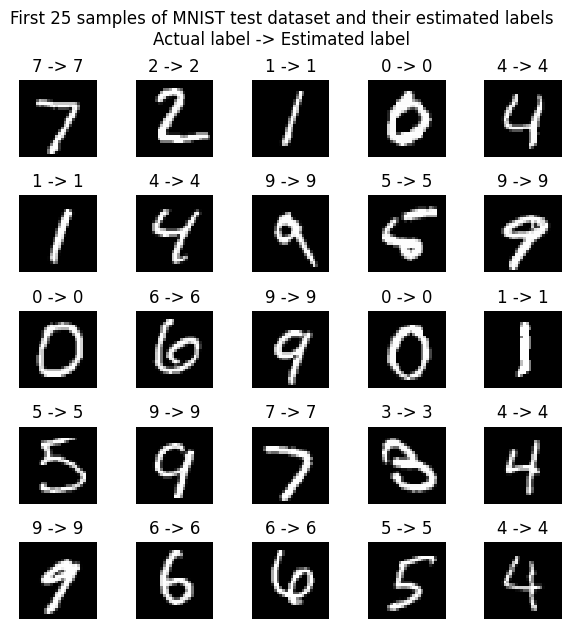

In [122]:
# Plot first 25 samples 
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 17: The first 25 images labeled by the Convolutional Neural Network model***

**Analysis of Figure 17:** Visualization of 25 labeled MNIST images classified using the Convolutional Neural Network model.

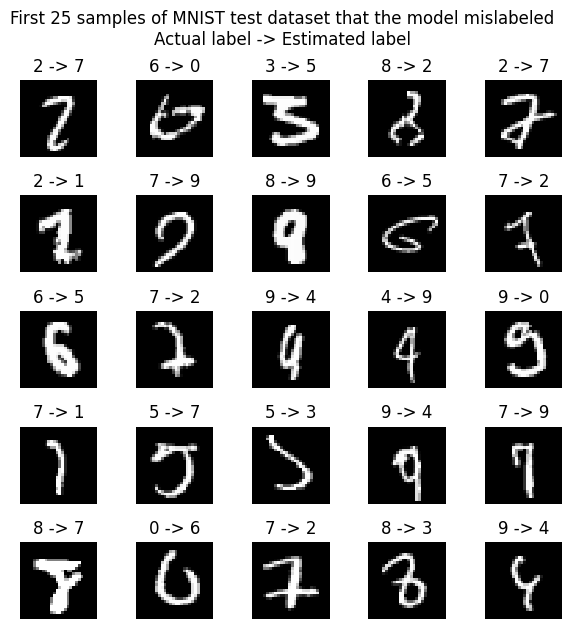

In [123]:
# Plot first 25 mislabeled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 18: The first 25 images mislabeled by the Convolutional Neural Network model***

**Analysis of Figure 18:** Visualization of 25 incorrectly labeled MNIST images classified using the Convolutional Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

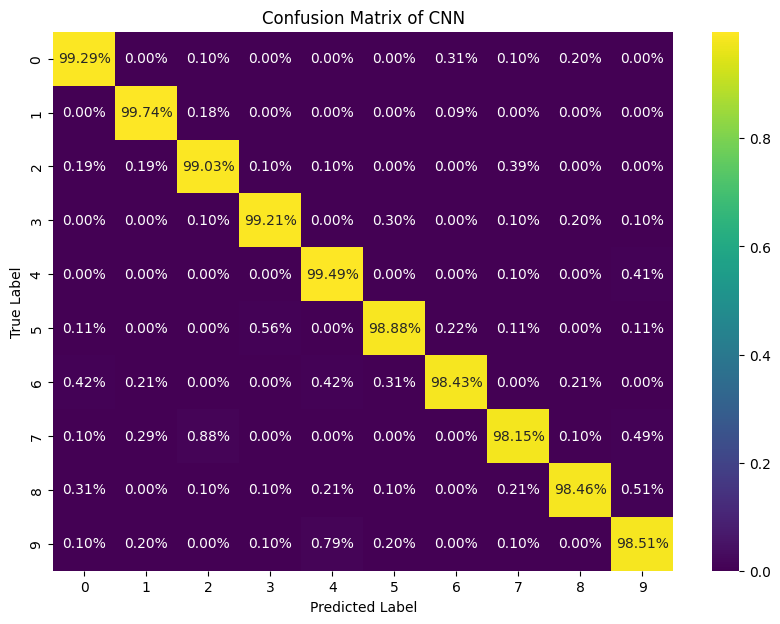

In [124]:
# Plot confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

***Figure 19: The confusion matrix of the Convolutional Neural Network model***

**Analysis of Figure 19:** Confusion matrix for the Convolutional Neural Network model classifying MNIST images. The high accuracy (0.9893) is supported by the matrix, showing minimal misclassifications across all digit classes. Notably, digits '0' and '1' exhibit the highest precision and recall. The balanced distribution of correct classifications highlights the model's effectiveness in accurately identifying handwritten digits.

In [125]:
# Print classification report
print('Convolutional Neural Network Classification Report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=4))

Convolutional Neural Network Classification Report:
              precision    recall  f1-score   support

           0     0.9878    0.9929    0.9903       980
           1     0.9921    0.9974    0.9947      1135
           2     0.9865    0.9903    0.9884      1032
           3     0.9921    0.9921    0.9921      1010
           4     0.9849    0.9949    0.9899       982
           5     0.9899    0.9888    0.9893       892
           6     0.9937    0.9843    0.9890       958
           7     0.9892    0.9815    0.9854      1028
           8     0.9928    0.9846    0.9887       974
           9     0.9842    0.9851    0.9846      1009

    accuracy                         0.9893     10000
   macro avg     0.9893    0.9892    0.9892     10000
weighted avg     0.9893    0.9893    0.9893     10000



The classification report demonstrates that the model performs exceptionally well on the MNIST dataset, achieving an overall accuracy of 0.9893. Each digit class exhibits high precision, recall, and F1-scores, with all the values above 0.98. Notably, digits '0' and '1' have the highest F1-scores, with 0.9903 and 0.9947, respectively. The macro and weighted averages for precision, recall, and F1-score are all around 0.9882 to 0.9883, reflecting the model's strong performance. 

## **Simple Residual Neural Network (ResNet)**

The residual neural network (ResNet) is a deep learning architecture, introduced by researchers at Microsoft, in which the weight layers learn residual functions with references to the layer inputs. Typically, ResNet is typically used in networks with hundreds of layers to avoid the degradation problem.

**The Degradation Problem:** The degredation problem refers to the phenomenon where increasing the depth of a neural network beyond a certain point results in higher training error and worse performance due to vanishing gradients. To address this problem, ResNets introduce residual connections that bypass layers within residual blocks by adding the inputs directly to the outputs of those layers. 

**Residual Blocks:** Consider a subnetwork with a certain number of stacked layers. Let $f(x)$ denote the underlying function performed by this subnetwork, where $x$ is the input into the subnetwork. Residual learning reparametrizes this subnetwork and lets the parameter layers represent a residual function $g(x)=f(x)-x$, which is how the residual block derives its name. If the identity mapping $f(x)=x$ is the desired underlying mapping, the  residual mapping amounts to $g(x)=0$. The residual blocks allow inputs to propagate faster through the residual connections across layers. During backpropagation, the residual blocks allow the gradient to flow directly through the network, mitigating the vanishing gradient problem and making optimization easier. 

Here is a diagram of a regular block (left) and a residual block (right) from https://classic.d2l.ai/chapter_convolutional-modern/resnet.html.

<img src="mnist_classification_pics/6.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 400px;"> 

**Identity Mappings:** The residual connections make it easier for the network to learn identity mappings. If additional layers do not contribute positively, then the weights and biases of the upper weight layer are pushed to $0$. And the identity mappings allow the network to simply pass the input through unnchanged.

**Batch Normalization:** This neural network uses batch normalization, a standardization of the inputs to a layer, applied to the activations of a prior layer. This has the effect of stablizing the learning process and reducing the number of training epochs required. Batch normalization deals with the problem of internal covariate shift. 

**Internal Covariate Shift:** Training deep neural networks is complicated by the fact that the distribution of each layer's inputs change during training, as the parameters of the previous layers change. This change in distribution is called internal covariate shift. It slows down the training by requiring lower learning rates. Batch normalization standardizes the activations of each input variable per layer, rescaling data be a standard Gaussian (mean $0$ standard deviation $1$). This leads us closer to achieving the fixed distributino of inputs that would remove the effects of the internal covariate shift. 


I will construct a model similar to a ResNet-9 model discussed by Zhiyuan Li et al. (2022), whose model architecture is depicted here:

<img src="mnist_classification_pics/5.png" style="display: block; margin-left: auto; margin-right: auto; max-width: 800px;"> 

In [45]:
def simple_residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    
    return x

# Define the simpler ResNet model
def define_simple_ResNet_model():
    inp = layers.Input(shape=(28, 28, 1), name='InputLayer')
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    
    # The simple residual blocks
    x = simple_residual_block(x, 64)
    x = simple_residual_block(x, 64)
    x = simple_residual_block(x, 64)
 

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(.4, seed=1)(x)
    outp = layers.Dense(10, activation='softmax')(x)
    
    # Create the model
    model = Model(inp, outp, name='SimpleResNetModel')
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
model = define_simple_ResNet_model()


# Compile the model
# model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

# Summarize the model
model.summary()

Model: "SimpleResNetModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 28, 28,    │        640 │ InputLayer[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 28, 28,    │     36,928 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │     36,928 │ activation_29[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 28, 28,    │          0 │ activation_28[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 28, 28,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │     36,928 │ activation_30[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 28, 28,    │     36,928 │ activation_31[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 28, 28,    │          0 │ activation_30[0]

 Total params: 3,499,414 (13.35 MB)

 Trainable params: 3,498,390 (13.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [46]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=15,
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='ResNetModelCheckPoints/best_ResNet_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='ResNetModelCheckPoints/ResNet_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 412s 219ms/step - accuracy: 0.8887 - loss: 0.4059 - val_accuracy: 0.9773 - val_loss: 0.0708
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 415s 221ms/step - accuracy: 0.9792 - loss: 0.0741 - val_accuracy: 0.9885 - val_loss: 0.0399
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 419s 224ms/step - accuracy: 0.9864 - loss: 0.0497 - val_accuracy: 0.9882 - val_loss: 0.0419
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 427s 228ms/step - accuracy: 0.9905 - loss: 0.0344 - val_accuracy: 0.9884 - val_loss: 0.0354
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 431s 230ms/step - accuracy: 0.9911 - loss: 0.0307 - val_accuracy: 0.9912 - val_loss: 0.0282
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 425s 226ms/step - accuracy: 0.9943 - loss: 0.0201 - val_accuracy: 0.9911 - val_loss: 0.0325
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 440s 235ms/step - accuracy: 0.9951 - loss: 0.0176 - val_accuracy: 0.9921 - val_loss: 0.0266
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 435s 232ms/step - ac

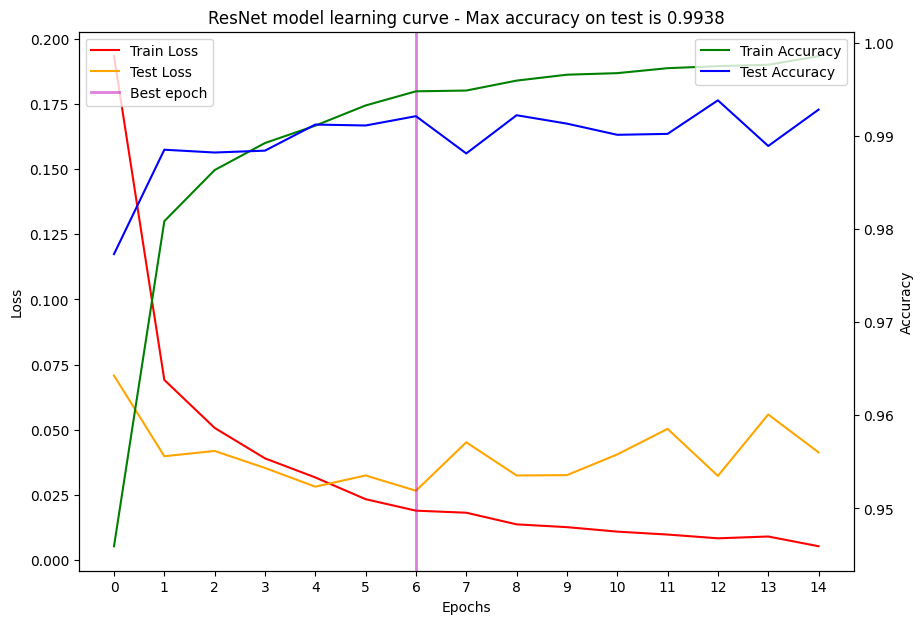

In [48]:
# Plot learning curves and labelling them
filename='ResNetModelLearningCurve.png'
model_name = 'ResNet' 
plot_history(history, filename, model_name, 15)

***Figure 20: ResNet's learning curve.***

**Analysis of Figure 16:** The learning curve of ResNet indicates a somewhat fluctuating learning performance, with the maximum test accuracy reaching 0.9938 on the 13th epich. The 6th epoch marks the epoch of the lowest test loss. After the 6th epoch, the test losses fluctuate while the training losses continue on a downward trend, implying that the model struggles with overfitting. The ResNet achieved the highest test accuracy of all five models. 

In [71]:
# Load best model
model = load_model('ResNetModelCheckPoints/ResNet_model_13.keras')

In [80]:
# Find shape of prediction
test_y_hat = model.predict(test_x)
#print('test_y_hat shape is : ' + str(test_y_hat.shape))
#print(test_y_hat.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step


In [81]:
test_y_hat = test_y_hat.reshape((10000,10))

In [82]:
# Find minimum and maximum prediction values
test_y_hat = np.argmax(test_y_hat, axis=1)
#print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
ResNet_accuracy = accuracy_score(test_y, test_y_hat)

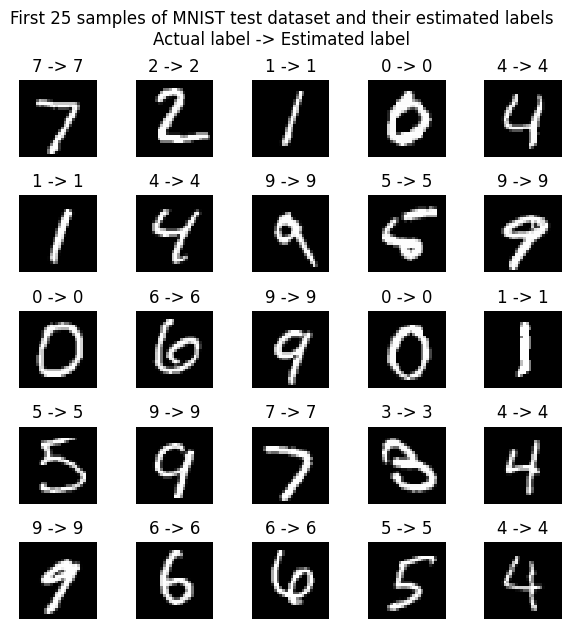

In [83]:
# Plot first 25 samples 
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 21: The first 25 images labeled by ResNet***

**Analysis of Figure 21:** Visualization of 25 labeled MNIST images classified using ResNet.

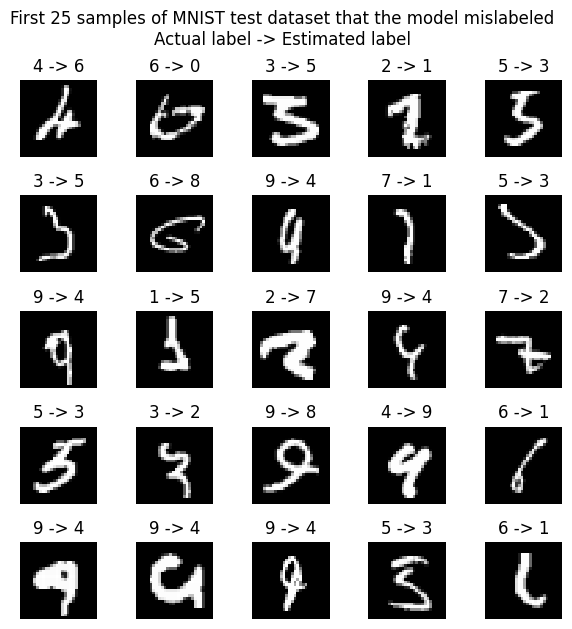

In [84]:
# Plot first 25 mislabeled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 22: The first 25 images mislabeled by ResNet***

**Analysis of Figure 22:** Visualization of 25 incorrectly labeled MNIST images classified using ResNet. 

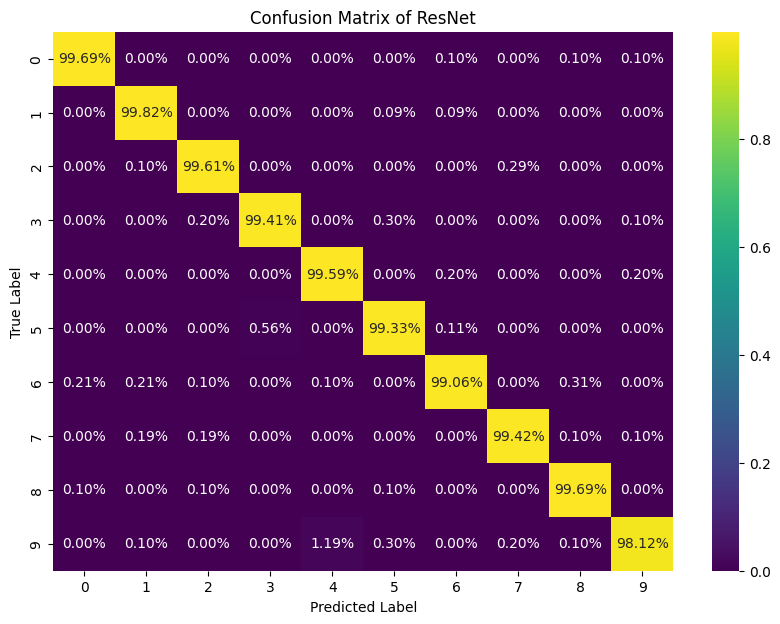

In [85]:
# Plot confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

***Figure 23: The confusion matrix of ResNet***

**Analysis of Figure 23:** Confusion matrix for ResNet classifying MNIST images. The digit '1' was the most accurately labeled, while the digit '9' was the least accurately labeled.

In [86]:
# Print classification report
print('ResNet Classification Report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=4))

ResNet Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9969    0.9969       980
           1     0.9947    0.9982    0.9965      1135
           2     0.9942    0.9961    0.9952      1032
           3     0.9950    0.9941    0.9946      1010
           4     0.9869    0.9959    0.9914       982
           5     0.9911    0.9933    0.9922       892
           6     0.9948    0.9906    0.9927       958
           7     0.9951    0.9942    0.9946      1028
           8     0.9939    0.9969    0.9954       974
           9     0.9950    0.9812    0.9880      1009

    accuracy                         0.9938     10000
   macro avg     0.9938    0.9937    0.9937     10000
weighted avg     0.9938    0.9938    0.9938     10000



The classification report demonstrates that ResNet achieves outstanding performance on the MNIST dataset, with an overall accuracy of .9938. Each digit class shows high precision, recall, and F1-scores, generally around or above 0.9900. Even the lowest-performing digit, '9', maintains a strong F1-score of 0.9880. The macro and weighted averages for all metrics are consistently around .9937 to .9938, reflecting the model's reliable performance.

## **Comparison of Random Forests, MLR, DNN, CNN, and ResNet**

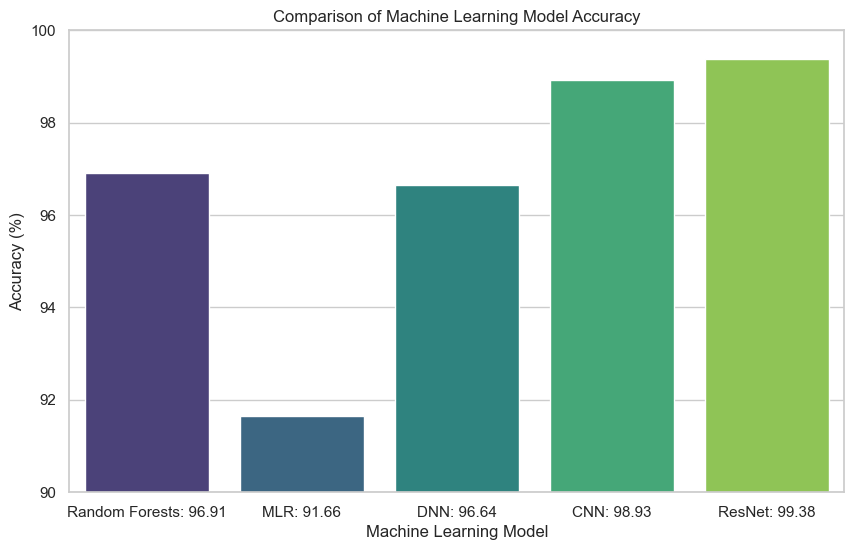

In [5]:
# Define data
data = {
    'Model': ['Random Forests: {:.2f}'.format(random_forests_accuracy*100),
              'MLR: {:.2f}'.format(MLR_accuracy*100), 
              'DNN: {:.2f}'.format(NN_accuracy*100), 
              'CNN: {:.2f}'.format(CNN_accuracy*100), 
              'ResNet: {:.2f}'.format(ResNet_accuracy*100)],
    
    'Accuracy': [random_forests_accuracy*100, MLR_accuracy*100, NN_accuracy*100, CNN_accuracy*100, ResNet_accuracy*100]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model', dodge=False, legend=False)

# Add titles and labels
plt.title('Comparison of Machine Learning Model Accuracy')
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy (%)')

# Restrict the y-axis
plt.ylim(90, 100)

# Display the plot
plt.show()

***Figure 24: Comparison of Machine Learning model accuracy***
**Analysis of Figure 24:** Comparing the accuracies of different models on the MNIST dataset, we observe varied performance levels. The Multinomial Logistic Regression (MLR) model has the lowest accuracy of .9166. The Dense Neural Network (DNN) model achieves the next best accuracy of .9664, showing strong performance but being lower than Random Forests, with an accuracy of .9691. The Convolutional Neural Network (CNN) outperforms Random Forests with an accuracy of .9893, demonstrating its strong capability in handling image data. The Residual Neural Network (ResNet) achieves the highest accuracy of .9938. It is the best model out of all models tested. For reference, the best ResNet is recorded to have a maximum accuracy of .9968, per the list of top MNIST classification models on https://paperswithcode.com/sota/image-classification-on-mnist. That indicates this particular ResNet is .003 less accurate than the best ResNet. 

### **References**

[1] Abouelnaga, Y., Elbadawy, M., Rashed, A., & Mahdy, Y. (2022). Predicting the future of stock markets using sentiment analysis and machine learning. arXiv preprint arXiv:2203.15331v2. Retrieved from https://arxiv.org/pdf/2203.15331v2

[2] Brownlee, J. (2016). Batch Normalization for Training of Deep Neural Networks. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

[3] Brownlee, J. (2019). How to Implement Major Architecture Innovations for Convolutional Neural Networks. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

[4] Capper, D., Jones, D. T. W., Sill, M., & Pfister, S. M. (2020). Methylation-based algorithms for diagnosis: Experience from neuro-oncology. ResearchGate. Retrieved from https://www.researchgate.net/publication/339279807_Methylation-based_algorithms_for_diagnosis_experience_from_neuro-oncology

[5] Google Developers. (n.d.). Machine Learning Glossary. Retrieved from https://developers.google.com/machine-learning/glossary

[6] Gupta, A. (2018). A Comprehensive Guide to Convolutional Neural Networks — the ELI5 Way. Towards Data Science. Retrieved from https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

[7] Papers with Code. (n.d.). Image Classification on MNIST. Retrieved from https://paperswithcode.com/sota/image-classification-on-mnist

[8] Wang, X., Zhao, W., & Zhang, J. (2022). Diagnosis of rotor demagnetization and eccentricity faults for IPMSM based on deep CNN and image recognition. ResearchGate. Retrieved from https://www.researchgate.net/publication/360875666_Diagnosis_of_rotor_demagnetization_and_eccentricity_faults_for_IPMSM_based_on_deep_CNN_and_image_recognition

[9] Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). ResNet. Dive into Deep Learning. Retrieved from https://d2l.ai/chapter_convolutional-modern/resnet.html